In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import os

In [2]:
zarr_path = "../preprocessing/data/features.zarr"
ds = xr.open_zarr(zarr_path)

D:\ML2025\PCPP\.venv\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


D:\ML2025\PCPP\.venv\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


Dataset structure:
<xarray.Dataset> Size: 11MB
Dimensions:                              (station: 183,
                                          forecast_reference_time: 21, t: 21)
Coordinates:
  * forecast_reference_time              (forecast_reference_time) datetime64[ns] 168B ...
    elevation                            (station) float64 1kB ...
    longitude                            (station) float64 1kB ...
    latitude                             (station) float64 1kB ...
    model_height_difference              (station) float64 1kB ...
    grid_idx                             (station) float64 1kB ...
  * station                              (station) object 1kB 'ABO' ... 'ZER'
  * t                                    (t) float64 168B 0.0 6.0 ... 120.0
Data variables: (12/17)
    coe_dew_point_depression_ensavg      (station, forecast_reference_time, t) float64 646kB ...
    coe_air_temperature_ensavg           (station, forecast_reference_time, t) float64 646kB ...
    coe_

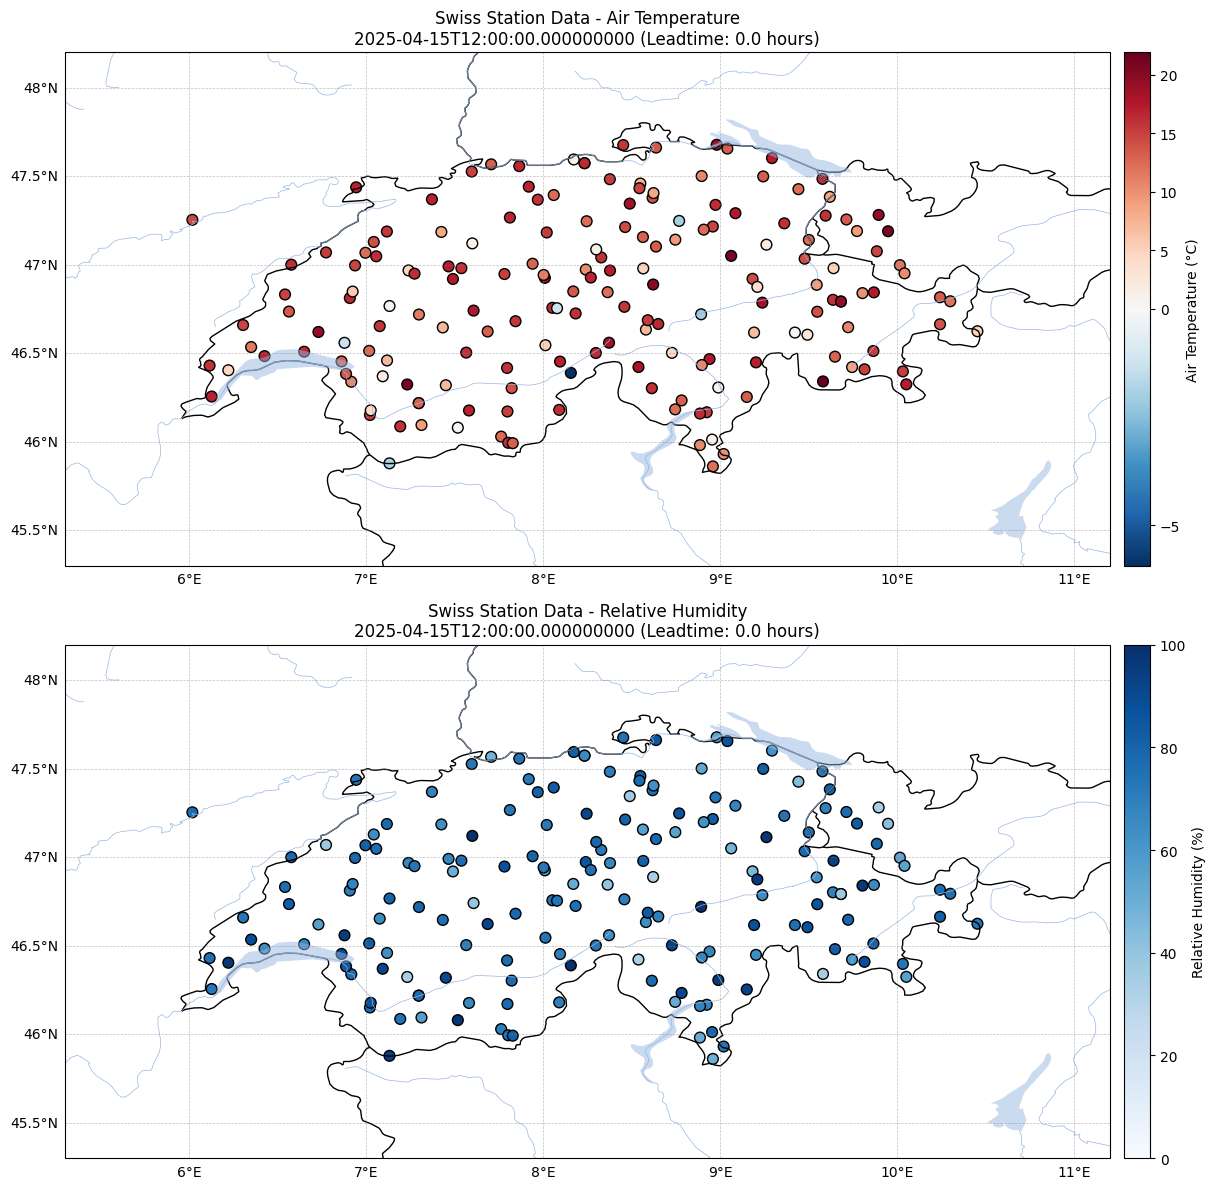

Visualization completed and saved as 'swiss_station_data.png'.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Open the dataset
ds = xr.open_zarr("../preprocessing/data/features.zarr")

print("Dataset structure:")
print(ds)

# Approximate borders for Switzerland
lat_min, lat_max = 45.5, 48.0  # Latitude range for Switzerland
lon_min, lon_max = 5.5, 11.0   # Longitude range for Switzerland

# Get station lat/lon coordinates
if 'latitude' in ds.coords:
    station_lats = ds.latitude.values
    station_lons = ds.longitude.values
    print("Coordinates found in coords")
elif 'latitude' in ds.data_vars:
    # Get coordinates for the first time and leadtime
    first_time = ds.forecast_reference_time.values[0]
    first_t = ds.t.values[0]
    station_lats = ds.latitude.sel(forecast_reference_time=first_time, t=first_t).values
    station_lons = ds.longitude.sel(forecast_reference_time=first_time, t=first_t).values
    print("Coordinates found in data_vars")
else:
    raise ValueError("Latitude and longitude data not found!")

print(f"The dataset contains {len(station_lats)} stations")

# Filter stations within Swiss borders
mask = ((station_lats >= lat_min) & (station_lats <= lat_max) &
        (station_lons >= lon_min) & (station_lons <= lon_max))

if isinstance(mask, np.ndarray) and len(mask) > 0:
    filtered_stations = ds.station.values[mask]
    print(f"{len(filtered_stations)} stations remain after filtering")
else:
    print("Filtering failed, using all stations")
    filtered_stations = ds.station.values

# Filter the dataset by stations
ds_filtered = ds.sel(station=filtered_stations)

# Select a specific time and leadtime for visualization
time_idx = 0  # First time index
leadtime_idx = 0  # First leadtime index (t)

selected_time = ds_filtered.forecast_reference_time.values[time_idx]
selected_leadtime = ds_filtered.t.values[leadtime_idx]

print(f"Selected time: {selected_time}, Leadtime: {selected_leadtime}")

# Get temperature values
if 'latitude' in ds.coords:
    latitudes = ds_filtered.latitude.values
    longitudes = ds_filtered.longitude.values
    temperatures = ds_filtered['coe_air_temperature_ensavg'].sel(
        forecast_reference_time=selected_time,
        t=selected_leadtime
    ).values
else:
    latitudes = ds_filtered.latitude.sel(
        forecast_reference_time=selected_time,
        t=selected_leadtime
    ).values
    longitudes = ds_filtered.longitude.sel(
        forecast_reference_time=selected_time,
        t=selected_leadtime
    ).values
    temperatures = ds_filtered['coe_air_temperature_ensavg'].sel(
        forecast_reference_time=selected_time,
        t=selected_leadtime
    ).values

# Get elevations (if available)
try:
    if 'elevation' in ds.coords:
        elevations = ds_filtered.elevation.values
    else:
        elevations = ds_filtered.elevation.sel(
            forecast_reference_time=selected_time,
            t=selected_leadtime
        ).values
    has_elevation = True
except:
    has_elevation = False
    elevations = np.ones_like(temperatures) * 100  # Default elevation value

print(f"{len(latitudes)} station data points prepared for visualization")

# Visualization
fig = plt.figure(figsize=(15, 12))

# Main map (temperature)
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_min-0.2, lon_max+0.2, lat_min-0.2, lat_max+0.2], crs=ccrs.PlateCarree())

# Add map features
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=1)
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.RIVERS, linewidth=0.5)

# Plot temperature data
vmin, vmax = np.min(temperatures), np.max(temperatures)
if vmin < 0 and vmax > 0:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = None

sc1 = ax1.scatter(longitudes, latitudes, c=temperatures,
                  cmap='RdBu_r', norm=norm,
                  transform=ccrs.PlateCarree(),
                  s=60, marker='o', edgecolor='black')

# Add colorbar
cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.01)
cbar1.set_label('Air Temperature (°C)')

# Title
ax1.set_title(f'Swiss Station Data - Air Temperature\n{selected_time} (Leadtime: {selected_leadtime} hours)')

# Add gridlines
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Second map (humidity if available)
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min-0.2, lon_max+0.2, lat_min-0.2, lat_max+0.2], crs=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=1)
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(cfeature.RIVERS, linewidth=0.5)

# Plot relative humidity (if available)
try:
    if 'coe_relative_humidity_ensavg' in ds_filtered:
        if 'latitude' in ds.coords:
            humidity = ds_filtered['coe_relative_humidity_ensavg'].sel(
                forecast_reference_time=selected_time,
                t=selected_leadtime
            ).values
        else:
            humidity = ds_filtered['coe_relative_humidity_ensavg'].sel(
                forecast_reference_time=selected_time,
                t=selected_leadtime
            ).values

        sc2 = ax2.scatter(longitudes, latitudes, c=humidity,
                          cmap='Blues', vmin=0, vmax=100,
                          transform=ccrs.PlateCarree(),
                          s=60, marker='o', edgecolor='black')

        cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.01)
        cbar2.set_label('Relative Humidity (%)')

        ax2.set_title(f'Swiss Station Data - Relative Humidity\n{selected_time} (Leadtime: {selected_leadtime} hours)')
    else:
        # If no humidity data, show elevation
        sc2 = ax2.scatter(longitudes, latitudes, c=elevations,
                          cmap='terrain',
                          transform=ccrs.PlateCarree(),
                          s=60, marker='o', edgecolor='black')

        cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.01)
        cbar2.set_label('Elevation (m)')

        ax2.set_title(f'Swiss Station Data - Elevation\n{selected_time}')
except Exception as e:
    print(f"Error while creating the second map: {e}")
    # Show elevation as fallback
    if has_elevation:
        sc2 = ax2.scatter(longitudes, latitudes, c=elevations,
                          cmap='terrain',
                          transform=ccrs.PlateCarree(),
                          s=60, marker='o', edgecolor='black')

        cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.01)
        cbar2.set_label('Elevation (m)')

        ax2.set_title(f'Swiss Station Data - Elevation\n{selected_time}')
    else:
        ax2.text(0.5, 0.5, "No additional data found",
                 transform=ax2.transAxes, ha='center', va='center', fontsize=14)

# Add gridlines
gl = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.tight_layout()
plt.savefig("swiss_station_data.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved as 'swiss_station_data.png'.")


Coordinates found in coords.
180 stations are within Switzerland.


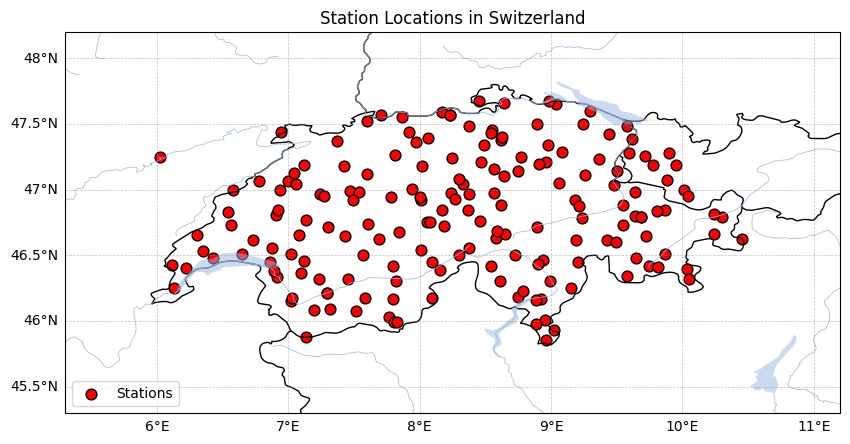

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# İsviçre sınırları (yaklaşık)
lat_min, lat_max = 45.5, 48.0
lon_min, lon_max = 5.5, 11.0

# İstasyon koordinatlarını al
if 'latitude' in ds.coords:
    station_lats = ds.latitude.values
    station_lons = ds.longitude.values
    print("Coordinates found in coords.")
elif 'latitude' in ds.data_vars:
    first_time = ds.forecast_reference_time.values[0]
    first_t = ds.t.values[0]
    station_lats = ds.latitude.sel(forecast_reference_time=first_time, t=first_t).values
    station_lons = ds.longitude.sel(forecast_reference_time=first_time, t=first_t).values
    print("Coordinates found in data_vars.")
else:
    raise ValueError("Latitude and longitude data not found!")

# İsviçre sınırları içinde kalan istasyonları filtrele
mask = ((station_lats >= lat_min) & (station_lats <= lat_max) &
        (station_lons >= lon_min) & (station_lons <= lon_max))

if isinstance(mask, np.ndarray) and len(mask) > 0:
    station_lats = station_lats[mask]
    station_lons = station_lons[mask]
    print(f"{len(station_lats)} stations are within Switzerland.")
else:
    print("No filtering applied, using all stations.")

# Görselleştirme
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Harita sınırlarını ayarla
ax.set_extent([lon_min - 0.2, lon_max + 0.2, lat_min - 0.2, lat_max + 0.2])

# Harita özellikleri
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# İstasyon lokasyonlarını çiz
ax.scatter(station_lons, station_lats,
           color='red', edgecolor='black', s=60, label='Stations')

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Başlık
ax.set_title('Station Locations in Switzerland')

# Legend
plt.legend(loc='lower left')

# Kaydet ve göster
plt.savefig("swiss_station_locations.png", dpi=300, bbox_inches='tight')
plt.show()
